# Progetto Visual Information Processing and Management
## Matteo Breganni 869549
## Lorenzo Monti 869960

# Dataset loading and exploration

## Imports

In [1]:
from google.colab import drive
import zipfile
import shutil
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random as python_random
import tensorflow as tf
from tensorflow import keras

np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)
keras.utils.set_random_seed(0)

## Dataset loading and preparation

This section imports the dataset zip files, extracts them and divides them into different folders based on the subset and the label, that are ready to be used efficiently and easily in every later stage of the project.

The result of this process is this folder structure:

```
Dataset/
    ├── train_labelled/
    │   ├── 0/
    │   ├── 1/
    │   ├── 2/
    │   ├── ...
    │   └── 250/
    ├── train_unlabelled/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   ├── image3.jpg
    │   ├── ...
    └── val/
        ├── 0/
        ├── 1/
        ├── 2/
        ├── ...
        └── 250/
```

where 'train_labelled' and 'val' contain the images divided by their label.

In [2]:
# Link Google Drive account
drive.mount('/content/drive')

# Copy dataset zip files, extract them and delete the zips
shutil.copy('/content/drive/My Drive/visual_train_set.zip', 'visual_train_set.zip')
zipf = zipfile.ZipFile('visual_train_set.zip')
zipf.extractall()
zipf.close()
os.remove('visual_train_set.zip')

shutil.copy('/content/drive/My Drive/visual_val_set.zip', 'visual_val_set.zip')
zipf = zipfile.ZipFile('visual_val_set.zip')
zipf.extractall()
zipf.close()
os.remove('visual_val_set.zip')

Mounted at /content/drive


In [3]:
# Count the number of files in the extracted folders
file_count_train_set = len([name for name in os.listdir('train_set') if os.path.isfile(os.path.join('train_set', name))])
print(f"There are {file_count_train_set} files in the 'train_set' directory.")

file_count_val_set = len([name for name in os.listdir('val_set') if os.path.isfile(os.path.join('val_set', name))])
print(f"There are {file_count_val_set} files in the 'val_set' directory.")

There are 118475 files in the 'train_set' directory.
There are 11994 files in the 'val_set' directory.


In [4]:
# Divide the train_set folder between labelled images and unlabelled images
extracted_train_folder_path = "/content/train_set"
train_labelled_path = "dataset/train_labelled"
train_unlabelled_path = "dataset/train_unlabelled"
train_csv_path = "/content/drive/My Drive/visual_train_small.csv"

# Load the CSV file without header and assign column names
train_csv_data = pd.read_csv(train_csv_path, header=None, names=['image_name', 'label'])
num_rows_train_csv = len(train_csv_data)
print(f"The number of rows in the CSV file is: {num_rows_train_csv}")

# If the training dataset has already been processed, dont re-process it
if(not os.path.exists(extracted_train_folder_path)):
    print("train_labelled and train_unlabelled folders have already been created")
else:
    # Pre-pend the folder path to the image names
    train_csv_data['image_path'] = train_csv_data['image_name'].apply(lambda x: os.path.join(extracted_train_folder_path, x))

    # Create directories to divide the dataset between
    os.makedirs(train_labelled_path, exist_ok=True)
    os.makedirs(train_unlabelled_path, exist_ok=True)

    # Function to move images to respective directories
    def move_images(data, destination):
        for _, row in data.iterrows():
            img_path = row['image_path']  # Full image path
            label = row['label']          # Label
            label_dir = os.path.join(destination, str(label))
            os.makedirs(label_dir, exist_ok=True)
            shutil.move(img_path, label_dir)

    # Move labelled images to train_labelled_path
    move_images(train_csv_data, train_labelled_path)

    # List all images in the train set folder
    train_set_images = os.listdir(extracted_train_folder_path)

    # Get the images that are not in the CSV
    unlabelled_images = [img for img in train_set_images if img not in train_csv_data['image_name'].values]

    # Move unlabelled images to train_unlabelled_path
    for img in unlabelled_images:
        img_path = os.path.join(extracted_train_folder_path, img)
        shutil.move(img_path, train_unlabelled_path)

    # Check if the folder is empty
    if not os.listdir(extracted_train_folder_path):  # If the folder is empty
        shutil.rmtree(extracted_train_folder_path)
        print(f"The folder '{extracted_train_folder_path}' has been deleted.")
    else:
        print(f"Error: The folder '{extracted_train_folder_path}' is not empty and cannot be deleted.")

The number of rows in the CSV file is: 5020
The folder '/content/train_set' has been deleted.


Total number of images: 5020
Number of categories: 251


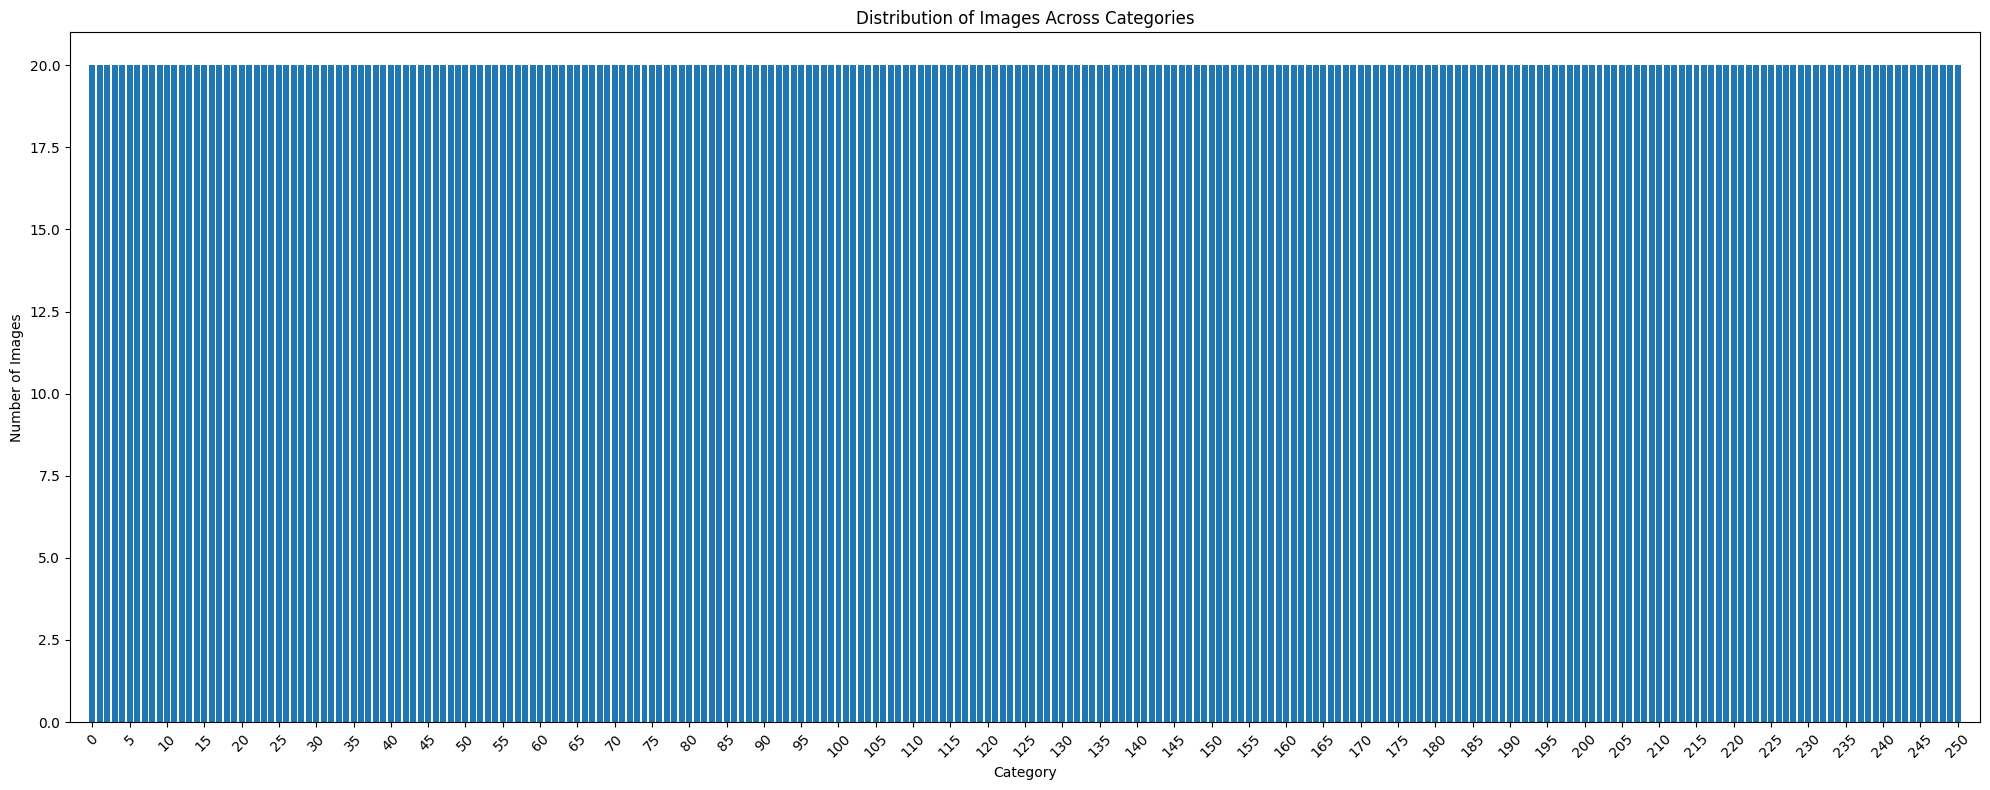

In [5]:
def plot_image_distribution_from_path(directory_path):
    # Get a list of all the subdirectories (categories)
    images_categories = sorted(
        [name for name in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, name))],
        key=lambda x: int(x)
    )

    # Count the number of images in each category
    category_counts = {}
    for category in images_categories:
        category_path = os.path.join(directory_path, category)
        image_count = len([name for name in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, name))])
        category_counts[category] = image_count

    # Print the number of images and categories
    file_count_labelled = sum(category_counts.values())
    print(f"Total number of images: {file_count_labelled}")
    print(f"Number of categories: {len(images_categories)}")

    # Plot the distribution of images across categories
    plt.figure(figsize=(20, 8))
    plt.bar(category_counts.keys(), category_counts.values())

    # Adjust x-axis limits to remove excessive white space
    plt.xlim(-3, len(images_categories) + 2)  # Small margin on both sides

    # Show only every 5th category label on the x-axis
    plt.xticks(ticks=range(0, len(images_categories), 5), labels=[images_categories[i] for i in range(0, len(images_categories), 5)], rotation=45)

    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Images Across Categories')
    plt.tight_layout()
    plt.show()

    # Return the category counts for later use
    return sum(category_counts.values())

file_count_labelled_train_set = plot_image_distribution_from_path(train_labelled_path)

In [8]:
# Count the number of files in the train_unlabelled folder, and verify that all the images have been sorted
file_count_unlabelled_train_set = len([name for name in os.listdir(train_unlabelled_path) if os.path.isfile(os.path.join(train_unlabelled_path, name))])
print(f"There are {file_count_unlabelled_train_set} files in the 'train_unlabelled' directory.")
print(f"There are {file_count_labelled_train_set} files in the 'train_labelled' directory.")

if(file_count_unlabelled_train_set + file_count_labelled_train_set == file_count_train_set):
    print("All the training images have been sorted")
else:
    print("There was an error in the division of the training images")

There are 113455 files in the 'train_unlabelled' directory.
There are 5020 files in the 'train_labelled' directory.
All the training images have been sorted


In [9]:
# Sort the imported validation images into category folders
extracted_val_folder_path = "/content/val_set"
val_csv_path = "/content/drive/My Drive/visual_val_info.csv"
val_path = "dataset/val"

# Load the CSV file without header and assign column names
val_csv_data = pd.read_csv(val_csv_path, header=None, names=['image_name', 'label'])
num_rows = len(val_csv_data)
print(f"The number of rows in the CSV file is: {num_rows}")

# If the validation dataset has already been processed, dont re-process it
if(not os.path.exists(extracted_val_folder_path)):
    print("val folder has already been created")
else:
    # Prepend the folder path to the image names
    val_csv_data['image_path'] = val_csv_data['image_name'].apply(lambda x: os.path.join(extracted_val_folder_path, x))

    # Create directories for validation
    os.makedirs(val_path, exist_ok=True)

    # Move labelled images to val_path
    move_images(val_csv_data, val_path)

    # List all images in the train set folder
    val_set_images = os.listdir(extracted_val_folder_path)

    # Check if the folder is empty
    if not os.listdir(extracted_val_folder_path):  # If the folder is empty
        shutil.rmtree(extracted_val_folder_path)
        print(f"The folder '{extracted_val_folder_path}' has been deleted.")
    else:
        print(f"Error: The folder '{extracted_val_folder_path}' is not empty and cannot be deleted.")

The number of rows in the CSV file is: 11994
The folder '/content/val_set' has been deleted.


Total number of images: 11994
Number of categories: 251


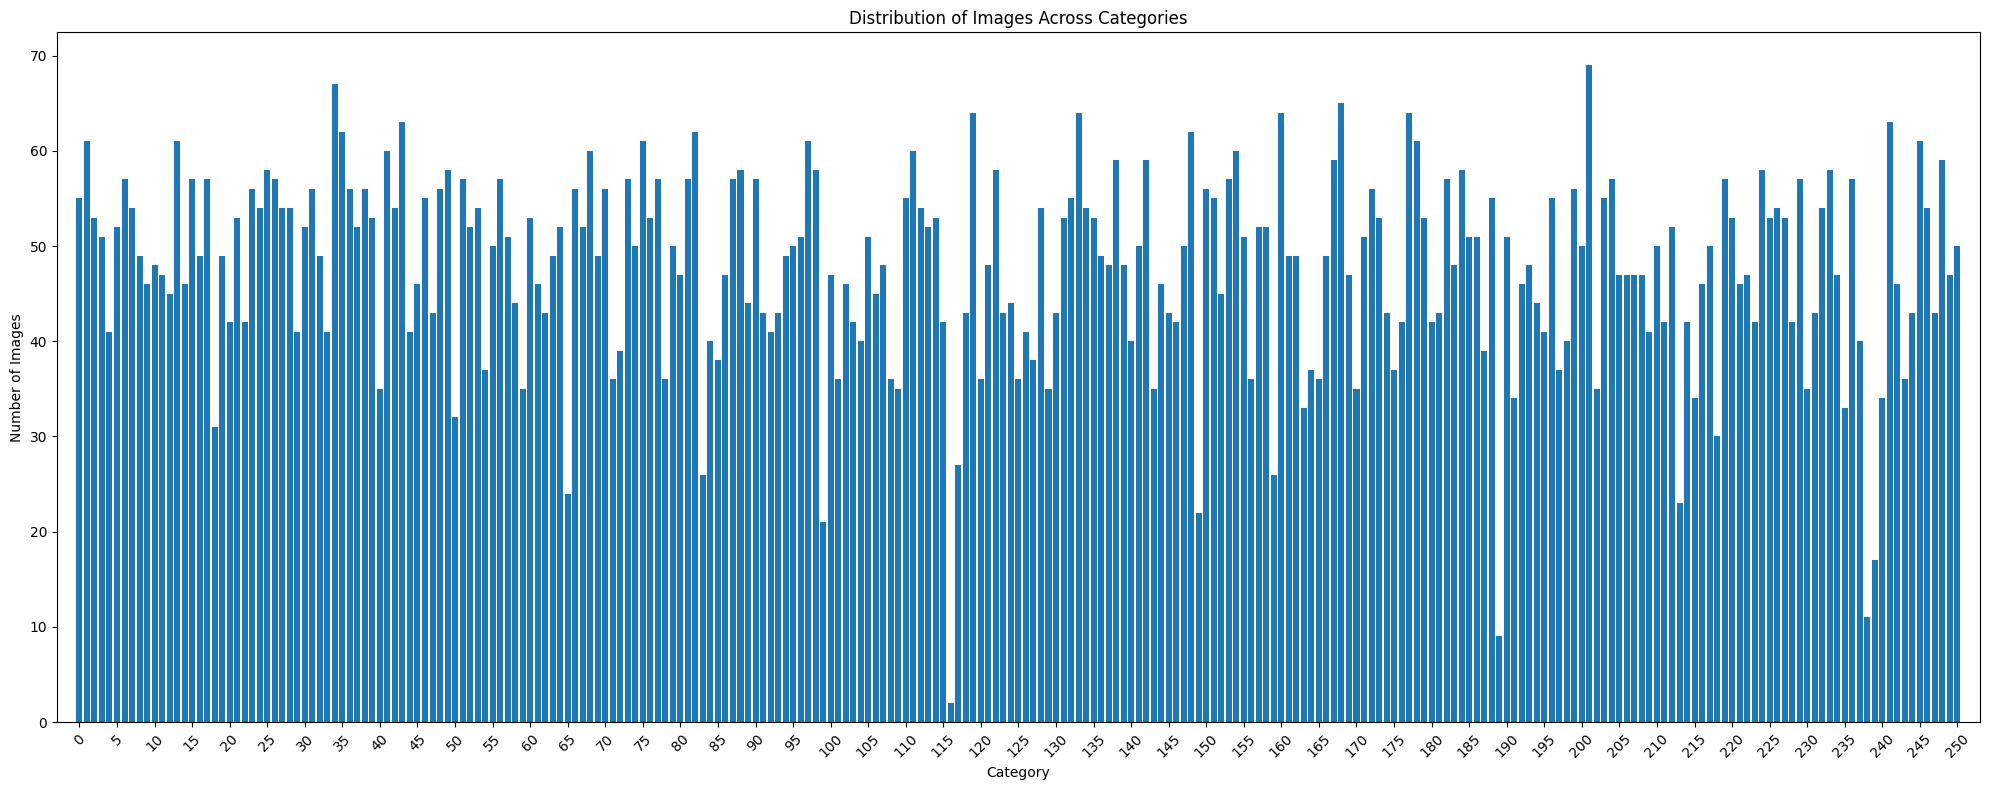

In [10]:
file_count_labelled_val_set = plot_image_distribution_from_path(val_path)

In [11]:
if(file_count_labelled_val_set == file_count_val_set):
    print("All the validation images have been sorted")
else:
    print("There was an error in the division of the validation images")

All the validation images have been sorted
